# Seizure classification

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import scipy
import tensorflow as tf
import keras
import mne
from scipy import signal
import seaborn as sns
from sklearn.preprocessing import RobustScaler, Normalizer, MinMaxScaler
from mne.time_frequency import psd_array_multitaper

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score, precision_score, f1_score

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import xgboost as xgb

import warnings
plt.rcParams["figure.figsize"] = [20,12]

## Load the dataset

In [6]:
train_fname = "train_data.csv"
train_info = "train_info.csv"

df_train = pd.read_csv(train_fname)
df_info = pd.read_csv(train_info)

In [7]:
df_train.head()

,train_01,train_02,train_03,train_04,train_05,train_06,train_07,train_08,train_09,train_10,train_11,train_12,train_13,train_14,train_15,train_16
0,-2.048142,-4.098955,-10.934997,0.680934,-4.782559,-3.415351,-19.821852,-3.415351,-12.649347,-10.934997,-20.510796,-11.623941,-58.103683,2.048142,38.962770,2.048142
1,-3.415351,-8.200580,-13.669414,-2.731746,-6.149767,-5.466163,-16.403830,-2.731746,-4.440757,-10.934997,-10.934997,-12.985809,-16.403830,1.364538,40.329975,2.048142
2,-3.415351,-12.302205,-8.884184,-6.149767,-5.466163,-5.466163,-12.302205,-2.731746,3.757153,-11.623941,-2.048142,-11.623941,47.166020,2.048142,38.962770,3.415351
3,-2.048142,-15.036622,-4.782559,-7.522316,-6.149767,-5.466163,-9.573129,-2.048142,1.022736,-11.623941,6.149767,-8.884184,75.877396,4.098955,38.279163,2.731746
4,-1.364538,-16.062027,-4.098955,-6.833372,-3.415351,-5.466163,-11.623941,-3.415351,-4.782559,-12.302205,12.302205,-6.833372,68.357750,6.149767,41.697186,1.364538


## Visualize the dataset

In [8]:
df_train.describe()

,train_01,train_02,train_03,train_04,train_05,train_06,train_07,train_08,train_09,train_10,train_11,train_12,train_13,train_14,train_15,train_16
count,307200.000000,307200.000000,307200.000000,307200.000000,307200.000000,307200.000000,307200.000000,307200.000000,307200.000000,307200.000000,307200.000000,307200.000000,307200.000000,307200.000000,307200.000000,307200.000000
mean,-4.911855,-2.738525,-2.827428,-2.299834,-4.154092,-4.373316,-3.912876,-2.420315,-2.776009,-3.252249,-4.224757,-3.361436,-3.195695,-2.361176,-4.455838,-4.095180
std,47.313222,11.832385,17.249817,34.079131,7.518448,23.809107,11.912898,8.850986,7.168921,65.023553,11.678908,29.405747,64.739671,62.784504,22.489399,21.013117
min,-175.000000,-175.000000,-175.000000,-174.316390,-67.674140,-175.000000,-175.000000,-175.000000,-62.547110,-175.000000,-111.424810,-175.000000,-175.000000,-175.000000,-175.000000,-175.000000
25%,-15.036622,-7.175174,-7.522316,-7.522316,-8.200580,-8.200580,-8.200580,-5.466163,-7.175174,-22.561607,-12.985809,-7.522316,-65.623330,-19.138247,-11.623941,-8.884184
50%,-4.782559,-2.731746,-3.415351,-2.048142,-4.098955,-4.782559,-4.098955,-2.048142,-3.073549,-2.731746,-4.098955,-3.415351,-0.680934,-2.731746,-4.098955,-4.098955
75%,5.466163,2.048142,1.364538,4.098955,0.002670,0.002670,0.680934,0.680934,1.706340,21.872663,4.782559,0.680934,58.787290,12.302205,3.415351,1.364538
max,172.949190,174.658200,174.658200,174.658200,61.521706,173.632800,168.158620,174.658200,69.719610,174.658200,58.103683,174.316390,174.316390,174.658200,173.632800,174.316390


array([[<AxesSubplot:title={'center':'train_01'}>,
        <AxesSubplot:title={'center':'train_02'}>,
        <AxesSubplot:title={'center':'train_03'}>,
        <AxesSubplot:title={'center':'train_04'}>],
       [<AxesSubplot:title={'center':'train_05'}>,
        <AxesSubplot:title={'center':'train_06'}>,
        <AxesSubplot:title={'center':'train_07'}>,
        <AxesSubplot:title={'center':'train_08'}>],
       [<AxesSubplot:title={'center':'train_09'}>,
        <AxesSubplot:title={'center':'train_10'}>,
        <AxesSubplot:title={'center':'train_11'}>,
        <AxesSubplot:title={'center':'train_12'}>],
       [<AxesSubplot:title={'center':'train_13'}>,
        <AxesSubplot:title={'center':'train_14'}>,
        <AxesSubplot:title={'center':'train_15'}>,
        <AxesSubplot:title={'center':'train_16'}>]], dtype=object)

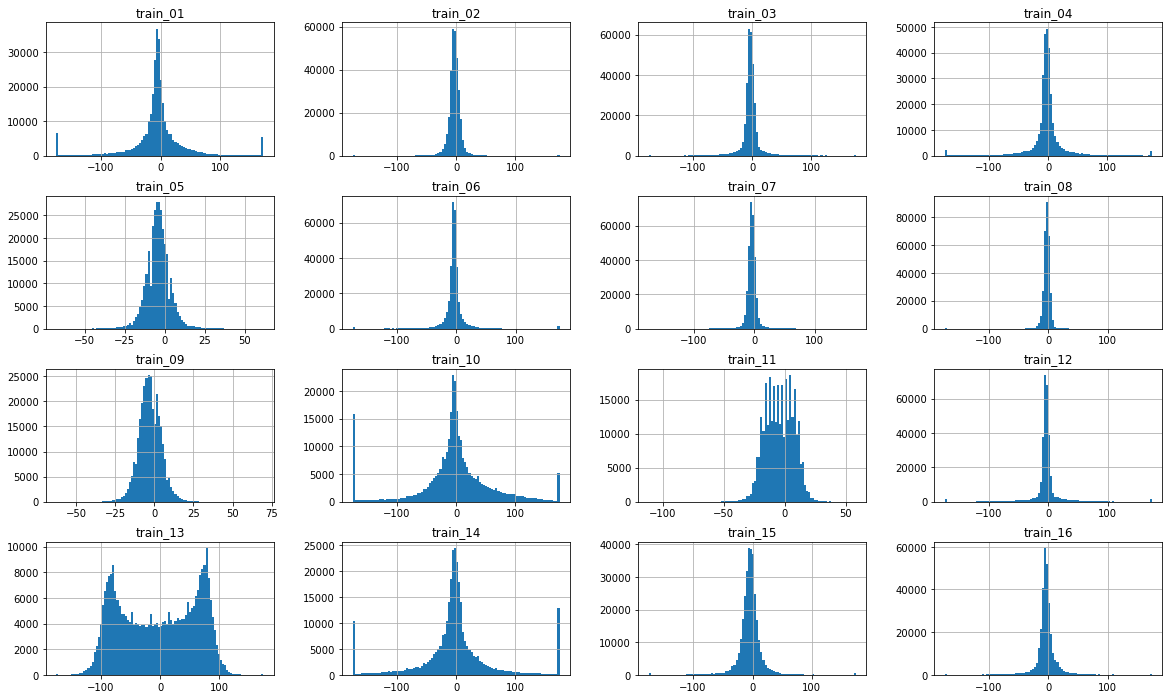

In [9]:
## We can look at the distribution of the data for each patient
df_train.hist(bins=100)

We observe different distributions of data across patients. We will need to account for this and address it with different preprocessing techniques, such as scaling methods.

Something else we can notice is the presence of extreme values for some of the patients (eg. train_01, train_10, train_14 etc.). We will need to understand if these values should be removed or if they belong to a certain pattern we could use for seizure classification.

We can now check if there are any missing values.  

In [10]:
df_train.isnull().sum()

train_01    0
train_02    0
train_03    0
train_04    0
train_05    0
train_06    0
train_07    0
train_08    0
train_09    0
train_10    0
train_11    0
train_12    0
train_13    0
train_14    0
train_15    0
train_16    0
dtype: int64

We don't observe any missing or NaN values in the dataset, we can go to the next step.

In [11]:
df_info

,file_id,pt_id,loc,sz_present,sz_type,t_start,t_end
0,train_01,C20,LE,1,IC - Focal Evolving to BL TC,77.0,155.0
1,train_02,A12,LF,0,NaN,NaN,NaN
2,train_03,C6,RE,1,IB - Focal Impaired Awareness,303.0,431.0
3,train_04,C14,RE,0,NaN,NaN,NaN
4,train_05,A3,LF,0,NaN,NaN,NaN
5,train_06,A6,RF,1,IB - Focal Impaired Awareness,354.0,463.0
6,train_07,A6,LF,1,IB - Focal Impaired Awareness,430.0,448.0
7,train_08,B8,RF,0,NaN,NaN,NaN
8,train_09,A12,LE,0,NaN,NaN,NaN
9,train_10,A25,RE,1,IA1 - Focal Aware w/Motor,200.0,299.0


### Let's visualize a seizure to understand what it looks like

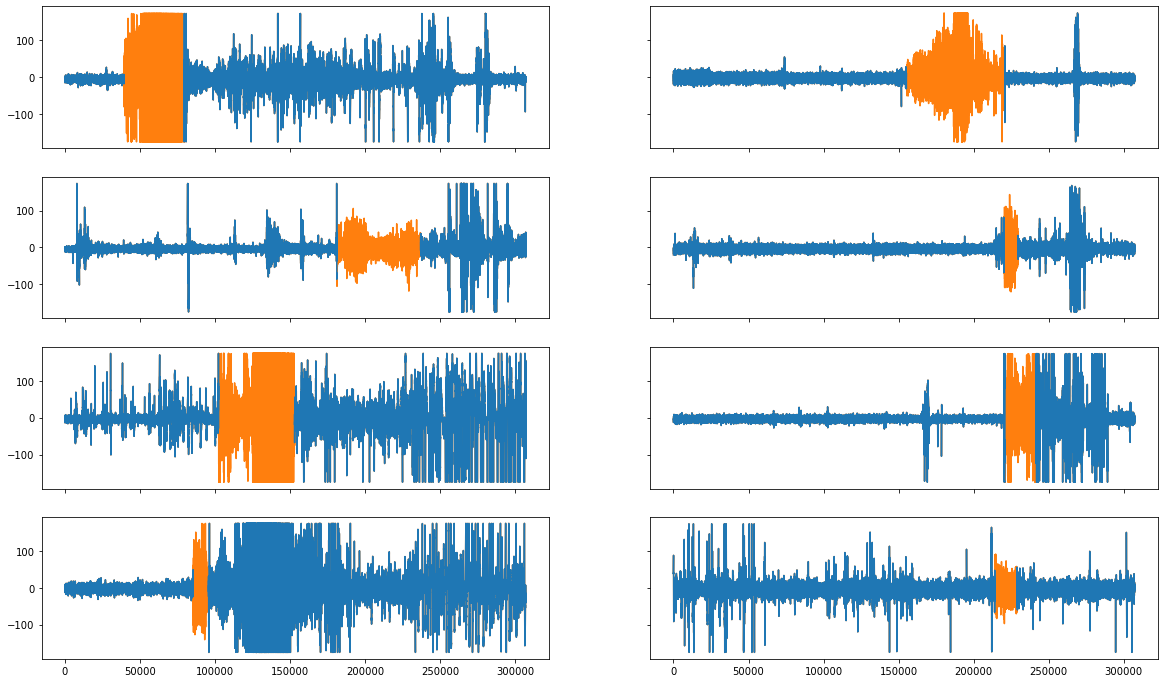

In [12]:
seizure_files = ['train_01', 'train_03', 'train_06', 'train_07', 'train_10', 'train_12', 'train_14', 'train_15']

plt.rcParams["figure.figsize"] = [20,12]
fig, axes = plt.subplots(4,2, sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    eeg_recording = df_train[seizure_files[i]]

    start = int(df_info['t_start'][df_info['file_id']==seizure_files[i]])*512
    end = int(df_info['t_end'][df_info['file_id']==seizure_files[i]])*512

    seizure_signal = eeg_recording.copy()
    baseline_signal = eeg_recording.copy()

    baseline_signal[start:end]=np.nan
    ax.plot(eeg_recording, color='tab:orange')
    ax.plot(baseline_signal, color='tab:blue')
    
plt.show()

The visualization of the seizures allows us to see if we can discriminate the seizures at first glance. This is obviously not possible for all seizures and we can notice the diversity of seizures' shapes.

## Create the target data

I am going to create a vector with the label "0" with there is no seizure and "1" if the seizure is happening.

In [13]:
def create_target_data(df, df_info):
    fs = 512   
    target_tot = []
    patients = df_info['file_id']
    seizure_lengths=[]
    for patient in patients:
        target = [0]*len(df)
        if df_info.loc[df_info['file_id'] == patient, 'sz_present'].iloc[0] == 1:
            start = int(df_info.loc[df_info['file_id'] == patient, 't_start'].iloc[0])*fs
            end = int(df_info.loc[df_info['file_id'] == patient, 't_end'].iloc[0])*fs
            seizure_lengths.append(end-start)
            target[start:end]=[1]*(end-start)
        target_tot.append(target)
    print(f'minimum seizure time = {min(seizure_lengths)/512} s, maximum seizure time = {max(seizure_lengths)/512} s')
    return target_tot

target_tot = create_target_data(df_train, df_info)

minimum seizure time = 18.0 s, maximum seizure time = 128.0 s


We print the min and max of the seizure lengths. This will be usefull later on to create appropriate window sizes.

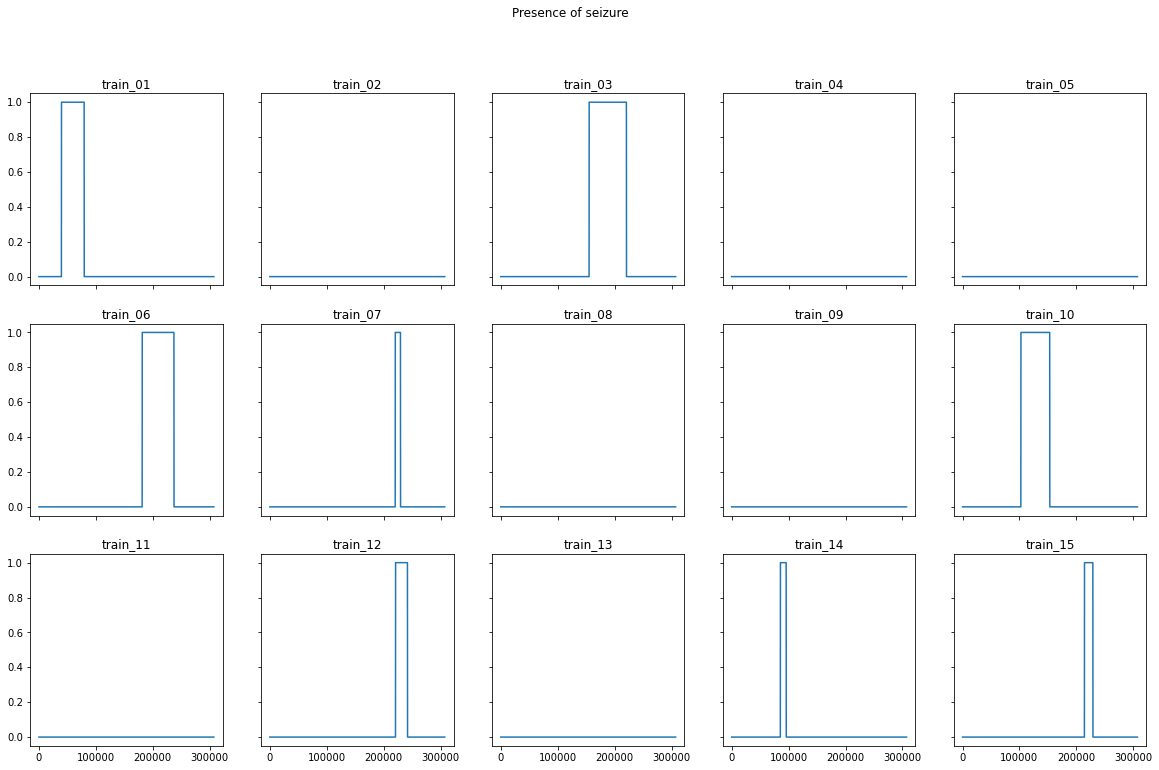

In [14]:
fig, axes = plt.subplots(3,5, sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    ax.plot(target_tot[i])
    ax.set_title(df_info['file_id'].loc[i])
plt.suptitle('Presence of seizure')
plt.show()

## Frequency features

We can take a look at the power spectral density

Text(0, 0.5, 'Power spectral density')

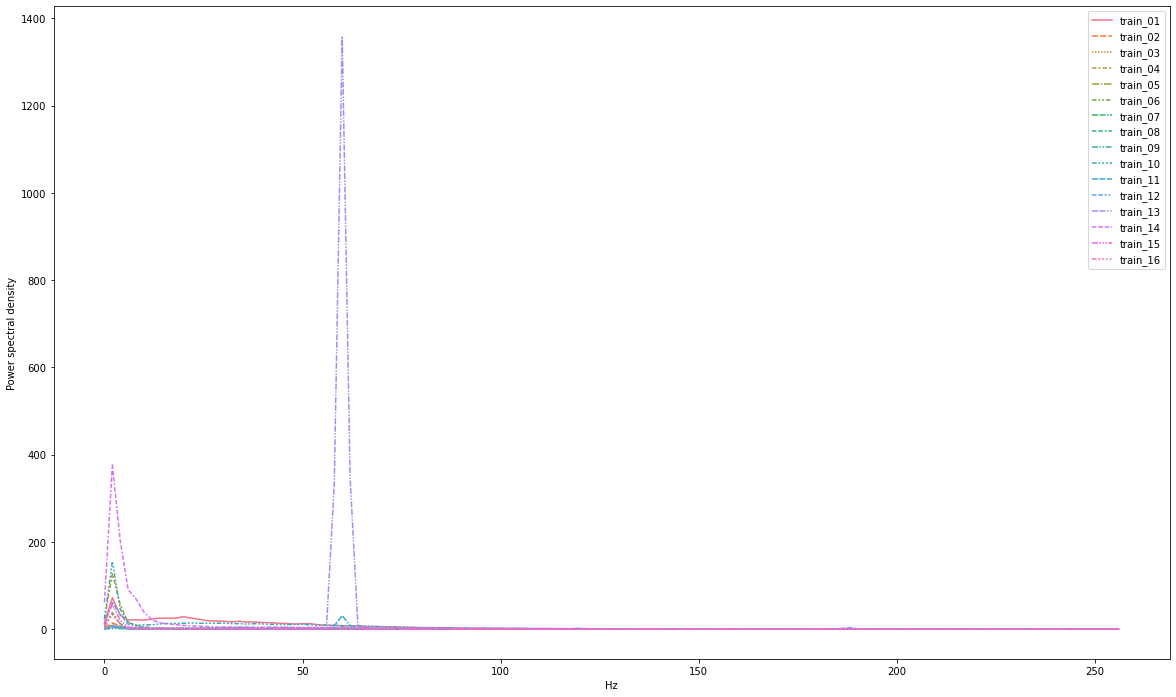

In [15]:
plt.rcParams["figure.figsize"] = [20,12]
from scipy.signal import welch
freqs, psd = welch(df_train, 
                   fs=512, 
                   axis=0)
psd = pd.DataFrame(psd, index = freqs, columns = df_train.columns)
psd.head()
sns.lineplot(data=psd)
plt.xlabel('Hz')
plt.ylabel('Power spectral density')

#### We can observe the big spike around 60hz for train_13. We can either remove this training data or run a Notch filter to remove the band between 50 and 65Hz, which corresponds to the AC line frequency.

In [16]:
df_train = df_train.drop('train_13', axis=1)

In [17]:
df_train.head()

,train_01,train_02,train_03,train_04,train_05,train_06,train_07,train_08,train_09,train_10,train_11,train_12,train_14,train_15,train_16
0,-2.048142,-4.098955,-10.934997,0.680934,-4.782559,-3.415351,-19.821852,-3.415351,-12.649347,-10.934997,-20.510796,-11.623941,2.048142,38.962770,2.048142
1,-3.415351,-8.200580,-13.669414,-2.731746,-6.149767,-5.466163,-16.403830,-2.731746,-4.440757,-10.934997,-10.934997,-12.985809,1.364538,40.329975,2.048142
2,-3.415351,-12.302205,-8.884184,-6.149767,-5.466163,-5.466163,-12.302205,-2.731746,3.757153,-11.623941,-2.048142,-11.623941,2.048142,38.962770,3.415351
3,-2.048142,-15.036622,-4.782559,-7.522316,-6.149767,-5.466163,-9.573129,-2.048142,1.022736,-11.623941,6.149767,-8.884184,4.098955,38.279163,2.731746
4,-1.364538,-16.062027,-4.098955,-6.833372,-3.415351,-5.466163,-11.623941,-3.415351,-4.782559,-12.302205,12.302205,-6.833372,6.149767,41.697186,1.364538


## Filtering tools

In [21]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band', output='sos')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.sosfiltfilt(sos, data)
    return y

def filter_dataset(df, fs, fhigh):
    df=df.copy()
    lowcut=0.1
    highcut=fhigh
    fs=fs
    columns = df.columns
    for col in columns:
        df[col] = butter_bandpass_filter(df[col], lowcut, highcut, fs, order=1)
    return df

df_train_filt = df_train

Text(0, 0.5, 'Power spectral density')

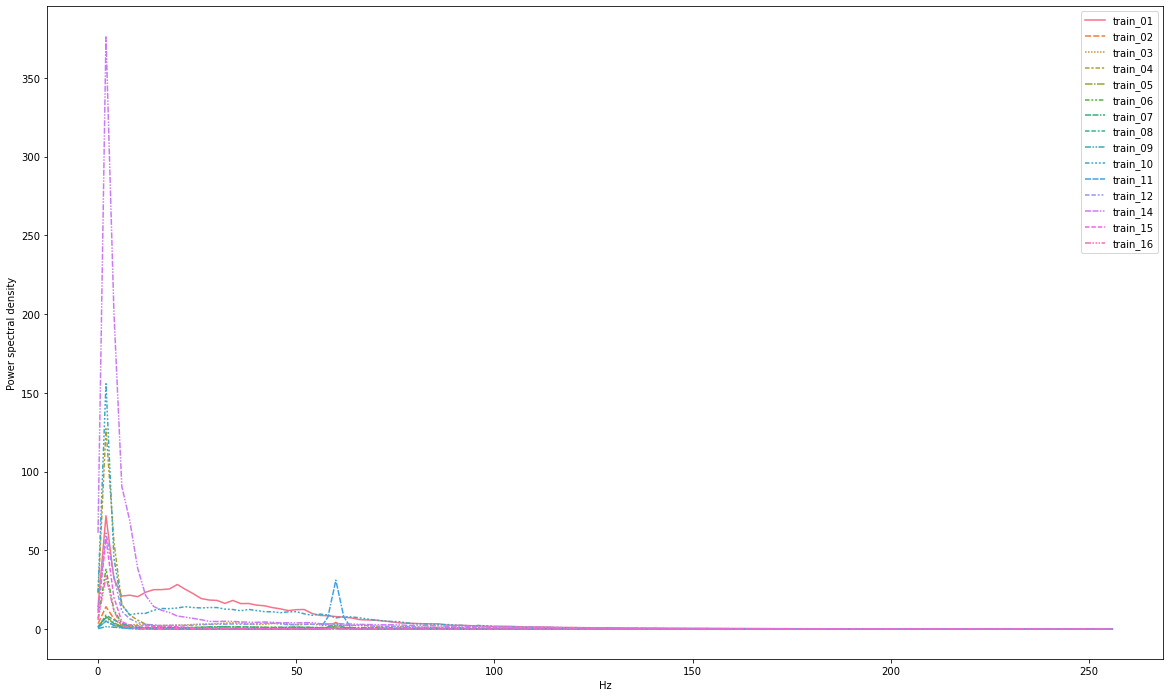

In [22]:
plt.rcParams["figure.figsize"] = [20,12]
from scipy.signal import welch
freqs, psd = welch(df_train_filt, 
                   fs=512, 
                   axis=0)
psd = pd.DataFrame(psd, index = freqs, columns = df_train.columns)
psd.head()
sns.lineplot(data=psd)
plt.xlabel('Hz')
plt.ylabel('Power spectral density')

array([[<AxesSubplot:title={'center':'train_01'}>,
        <AxesSubplot:title={'center':'train_02'}>,
        <AxesSubplot:title={'center':'train_03'}>,
        <AxesSubplot:title={'center':'train_04'}>],
       [<AxesSubplot:title={'center':'train_05'}>,
        <AxesSubplot:title={'center':'train_06'}>,
        <AxesSubplot:title={'center':'train_07'}>,
        <AxesSubplot:title={'center':'train_08'}>],
       [<AxesSubplot:title={'center':'train_09'}>,
        <AxesSubplot:title={'center':'train_10'}>,
        <AxesSubplot:title={'center':'train_11'}>,
        <AxesSubplot:title={'center':'train_12'}>],
       [<AxesSubplot:title={'center':'train_14'}>,
        <AxesSubplot:title={'center':'train_15'}>,
        <AxesSubplot:title={'center':'train_16'}>, <AxesSubplot:>]],
      dtype=object)

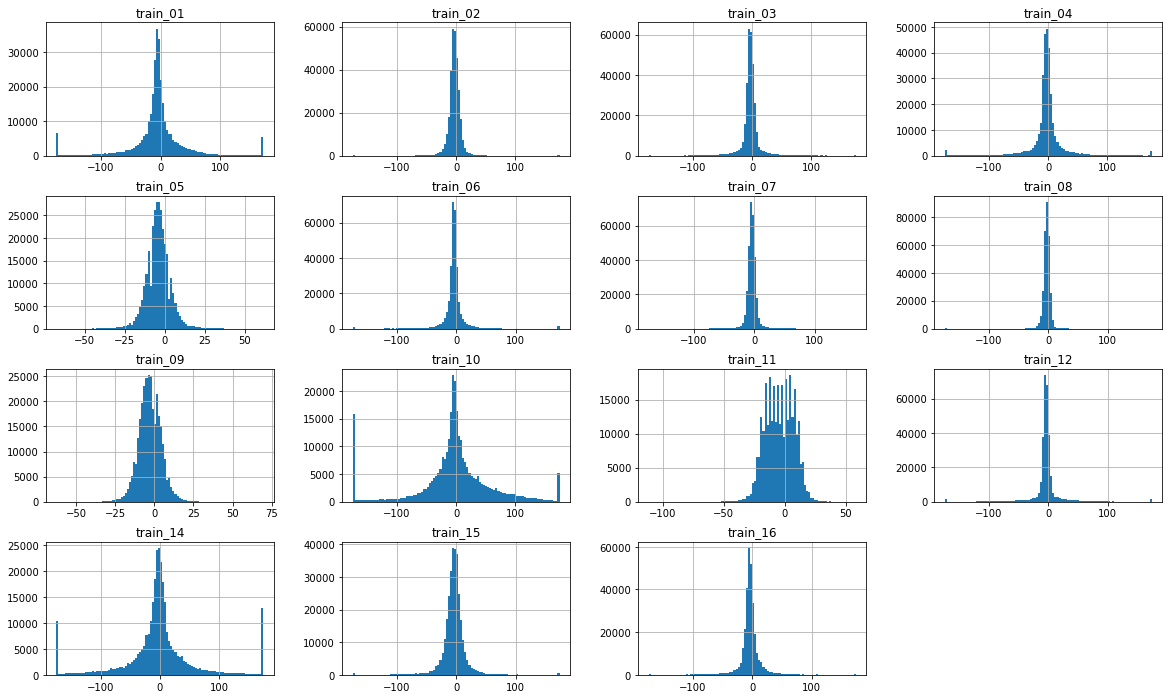

In [23]:
df_train_filt.hist(bins=100)

## Windowing

In [25]:
def threshold(x):
    if x>0.5:
        return 1
    elif x==0:
        return 0
    else:
        return None
## Cut windows before concatenating otherwise we will have overlaps between patients within the same window. 
def create_window_dataset_before_concat(df,tar):
    fs=512
    window_size = 18*fs # todo : run optimization on the window selected.
    shift = int(window_size/9)
    data_X = []
    data_Y = []
    for i, col in enumerate(df.columns):
        X=np.array(df[col])
        y=tar[i]
        for i in range(0, int(len(X)-window_size-1), shift):
            thresh = threshold(np.mean(y[i:i+window_size]))
            if thresh is not None:
                data_X.append(X[i:i+window_size])
                data_Y.append(thresh)
            else:
                continue
    return np.array(data_X), np.array(data_Y)

X_wind, y_wind = create_window_dataset_before_concat(df_train_filt,target_tot)

print(X_wind.shape, y_wind.shape)

(4291, 9216) (4291,)


ratio= 0.059659752971335356


/Users/eliecelnikier/miniconda3/envs/myenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


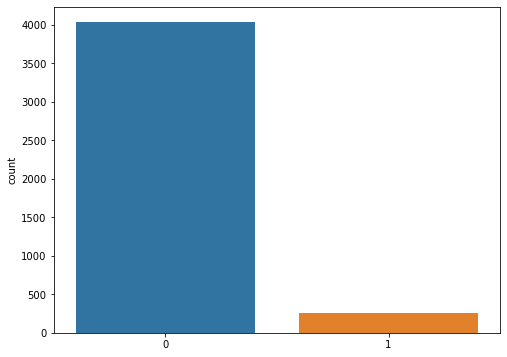

In [26]:
plt.rcParams["figure.figsize"] = [8,6]
sns.countplot(y_wind)
print('ratio=',np.sum(y_wind/len(y_wind)))

We observe an imbalanced dataset here. This can be dealt with using augmentation or reduction techniques as well as using appropriate machine learning algorithms.

## Feature Engineering

### Delta, theta, alpha, beta, gamma power

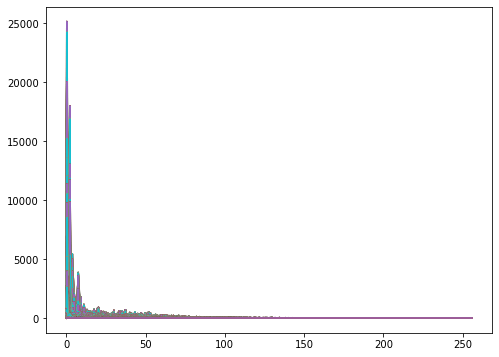

In [27]:
from scipy.signal import welch
def get_mean_power_freq(sign, band):
    sample_rate = 512 # in hz
    low = 0.5
    nperseg = (2 / low)*sample_rate
    freqs, psd = welch(sign, sample_rate,nperseg = nperseg, scaling='density' )
    plt.plot(freqs, psd)
    l=[psd[i] for i, f in enumerate(freqs) if f>band[0] and f<band[1]]
    return np.mean(l)

def create_power_features(sign):
    bandpass_data=[]
    bandpass_name=[]
    bandpasses = [[[0.1,4],'power_delta'],
                  [[4,8],'power_theta'],
                  [[8,12],'power_alpha'],
                  [[12,30],'power_beta'],
                  [[30,70],'power_gamma']
                 ]
    for bandpass, freq_name in bandpasses:
        bandpass_data.append(get_mean_power_freq(sign, bandpass))
        bandpass_name.append(freq_name)
    dico = dict(zip(bandpass_name, bandpass_data))
    
    return pd.DataFrame.from_dict(dico, orient='index').T

def create_df(data):
    tot=pd.DataFrame()
    for d in data:
        df = create_power_features(d)
        
        if tot.empty:
            tot = df

        else:
            tot = pd.concat([tot, df])
    return tot

power_df = create_df(X_wind)

### Discrete Wavelets

In [28]:
from pywt import wavedec

def create_wavelets(data):
    fs=512
    level = 6
    frequencies = np.array([fs]*level)
    j = [1<<exponent for exponent in range(level)]
    frequencies = frequencies/j
    coeffs_list = wavedec(data, wavelet='db4', level=level)
    #############################
    nums = list(range(1,level+1))
    names=[]
    for num in nums:
        names.append('D' + str(num))
    names.append('A' + str(nums[-1]))
    names = names[::-1] 
    ###########################
    wavelets = pd.DataFrame()
    for i, array in enumerate(coeffs_list):
        level_df = pd.DataFrame(array)
        level_df.columns = [names[i]]
        if wavelets.empty:
            wavelets = level_df
        else:
            wavelets = pd.concat([wavelets,level_df], axis=1)
    wavelets = wavelets.drop(f'A{str(level)}', axis=1)

    return wavelets, frequencies

def create_abs_mean_from_wavelets_df(data):
    data = data.copy()
    df = pd.DataFrame(data.abs().mean()).T
    df = df.rename(columns={"D6": "D6_abs_mean", "D5": "D5_abs_mean", 
                       "D4": "D4_abs_mean", "D3": "D3_abs_mean",
                       "D2": "D2_abs_mean", "D1": "D1_abs_mean"})
    return df
def create_mean_from_wavelets_df(data):
    data = data.copy()
    df = pd.DataFrame(data.mean()).T
    df = df.rename(columns={"D6": "D6_mean", "D5": "D5_mean", 
                           "D4": "D4_mean", "D3": "D3_mean",
                           "D2": "D2_mean", "D1": "D1_mean"})
    return df
def create_std_from_wavelets_df(data):
    data = data.copy()
    df = pd.DataFrame(data.std()).T
    df = df.rename(columns={"D6": "D6_std", "D5": "D5_std", 
                           "D4": "D4_std", "D3": "D3_std",
                           "D2": "D2_std", "D1": "D1_std"})
    return df

def create_logsum_from_wavelets_df(data):
    data = data.copy()
    df = pd.DataFrame(data.abs().sum()).T
    df = df.apply(np.log)
    df = df.rename(columns={"D6": "D6_logsum", "D5": "D5_logsum", 
                           "D4": "D4_logsum", "D3": "D3_logsum",
                           "D2": "D2_logsum", "D1": "D1_logsum"})
    return df
            
def create_wavelet_df(data):
    tot=pd.DataFrame()
    for d in data:
        wavelets_df, _ = create_wavelets(d)
        df_std = create_std_from_wavelets_df(wavelets_df)
        df_abs = create_abs_mean_from_wavelets_df(wavelets_df)
        df_mean = create_mean_from_wavelets_df(wavelets_df)
        df_logsum = create_logsum_from_wavelets_df(wavelets_df)
        df = pd.concat([df_abs], axis=1)
        if tot.empty:
            tot = df
        else:
            tot = pd.concat([tot, df])
    return tot
        
wave_df = create_wavelet_df(X_wind)

In [29]:
wave_df = wave_df.reset_index(drop=True)
power_df = power_df.reset_index(drop=True)
wave_df.head()

,D6_abs_mean,D5_abs_mean,D4_abs_mean,D3_abs_mean,D2_abs_mean,D1_abs_mean
0,8.516712,6.446451,4.554331,2.785415,1.459169,0.707534
1,9.094198,6.469276,4.544273,2.809347,1.454440,0.709191
2,8.830880,6.507426,4.567704,2.835682,1.472832,0.712035
3,8.526964,6.314840,4.653196,2.836315,1.472646,0.707656
4,8.846437,6.421694,4.566276,2.879510,1.479677,0.712058


In [30]:
print(power_df.shape)
print(wave_df.shape)
final_df = power_df.join(wave_df)
final_df.head()

(4291, 5)
(4291, 6)


,power_delta,power_theta,power_alpha,power_beta,power_gamma,D6_abs_mean,D5_abs_mean,D4_abs_mean,D3_abs_mean,D2_abs_mean,D1_abs_mean
0,2.235661,0.498033,0.291381,0.173867,0.046835,8.516712,6.446451,4.554331,2.785415,1.459169,0.707534
1,2.941097,0.496228,0.297095,0.173091,0.047505,9.094198,6.469276,4.544273,2.809347,1.454440,0.709191
2,3.644030,0.467211,0.312700,0.178587,0.047627,8.830880,6.507426,4.567704,2.835682,1.472832,0.712035
3,4.521552,0.474986,0.316643,0.171950,0.048543,8.526964,6.314840,4.653196,2.836315,1.472646,0.707656
4,4.597475,0.464725,0.310891,0.176840,0.048372,8.846437,6.421694,4.566276,2.879510,1.479677,0.712058


### Features correlation

<AxesSubplot:>

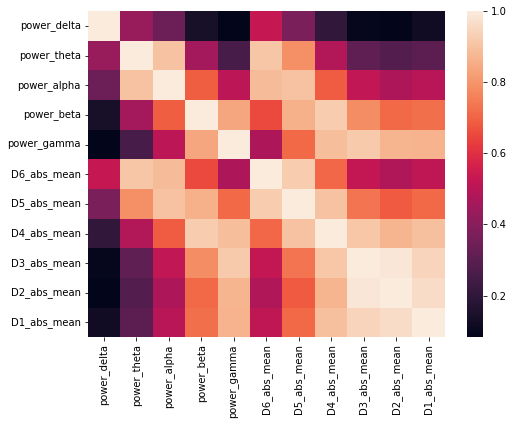

In [31]:
corr = final_df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Create train/test data

### Dealing with imbalanced dataset

In [25]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [27]:
over = SMOTE(sampling_strategy=1) #We could overfit if we adopt a strategy of more than 0.6
X_train, y_train = over.fit_resample(X_train, y_train)

/Users/eliecelnikier/miniconda3/envs/myenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

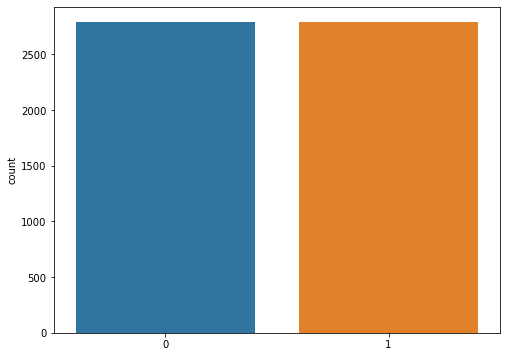

In [28]:
sns.countplot(y_train)

# Classic Machine Learning

Here we can test a bunch of classifiers like :

- K Nearest Neighbors
- Logistic Regression
- Ridge Regression
- Stochastic Gradient Descent 
- Naive Bayes, Decision Trees
- Random Forest
- Extreme Random Forest (ExtraTrees)
- Gradient Boosting
- Extreme Gradient Boosting (XGBoost).

## Train the classical models

In [30]:
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
# Logistic Regression
RANDOM_STATE=42

pipe_reg = Pipeline([('scl', StandardScaler()),
                     ('clf', LogisticRegression(class_weight='balanced',
                                                solver = 'liblinear',
                                                random_state=RANDOM_STATE))])

# Support Vector Machine
pipe_svc = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC(kernel='rbf', 
                                class_weight = 'balanced',
                                probability=True,
                                random_state=RANDOM_STATE))])

# Decision Tree
DT = DecisionTreeClassifier(random_state=RANDOM_STATE)

# K-Nearest Neighbours
pipe_kkn = Pipeline([('scl', StandardScaler()),
                    ('clf', KNeighborsClassifier())])

xgb_clf = xgb.XGBClassifier()

# list of classifier names
classifier_names = ['Logistic Regression', 'Support Vector Machine', 
                    'Decision Tree', 'K-Nearest Neighbors', 'XGBoost']

# list of classifiers
classifiers = [pipe_reg, pipe_svc, DT, pipe_kkn, xgb_clf]

# fit all the classifiers to the training data
for classifier in classifiers:
    classifier.fit(X_train, y_train)

## Visualize the results

In [68]:
from sklearn.metrics import multilabel_confusion_matrix
def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]

def plot_roc_auc(model, X_test, y_test):
    
    probas = model.predict_proba(X_test)[:, 1]
    
    roc_values = []
    
    for thresh in np.linspace(0, 1, 100):
        preds = get_preds(thresh, probas)
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        tpr = tp/(tp+fn)
        fpr = fp/(fp+tn)
        roc_values.append([tpr, fpr])
        
    tpr_values, fpr_values = zip(*roc_values)
    
    plt.plot(fpr_values, tpr_values)
    plt.plot(np.linspace(0, 1, 100),
             np.linspace(0, 1, 100),
             label='baseline',
             linestyle='--')
    
    plt.title('Receiver Operating Characteristic Curve', fontsize=18)
    plt.ylabel('TPR', fontsize=16)
    plt.xlabel('FPR', fontsize=16)
    plt.legend(fontsize=12)
    
def plot_conf_mat(y_test, y_pred, title):
    cf_matrix = confusion_matrix(y_test, y_pred)
    cf_matrix_pct = (cf_matrix / cf_matrix.sum(axis=1)[:, np.newaxis])*100
    
    auc = round(roc_auc_score(y_test,y_pred),2)
    f1 = round(f1_score(y_test, y_pred), 2)
    acc = round(accuracy_score(y_test, y_pred), 2)
    recall = round(recall_score(y_test, y_pred), 2)
    precision = round(precision_score(y_test, y_pred), 2)

    group_names = ["Baseline state \n correctly detected \n","False detection \n","Seizure not detected\n","Seizure detected\n"]
    group_counts = [f"{round(pct,2)}%\n{round(value,2)}" for value,pct in
                    zip(cf_matrix.flatten(), cf_matrix_pct.flatten())]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_names,group_counts)]

    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix_pct, annot=labels, fmt="", cmap="Blues")

    plt.figtext(0.45, -0.05, f"auc = {auc}\n f1 score = {f1}\n accuracy score = {acc} \n recall score = {recall} \n precision score = {precision}", ha="center", fontsize=10)
    
    plt.title(title)
    plt.show()

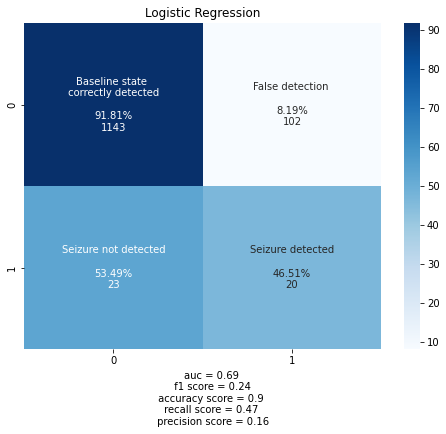

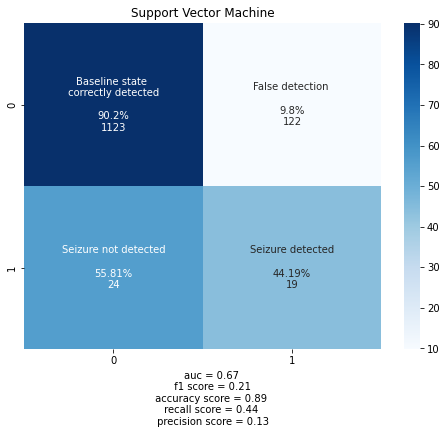

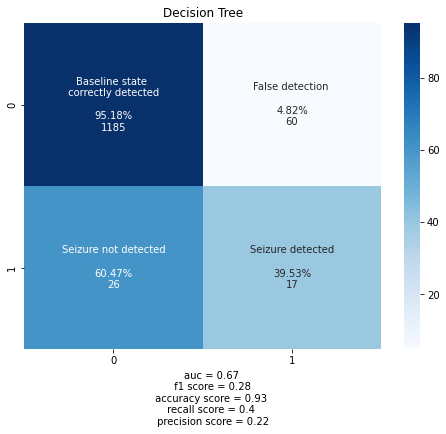

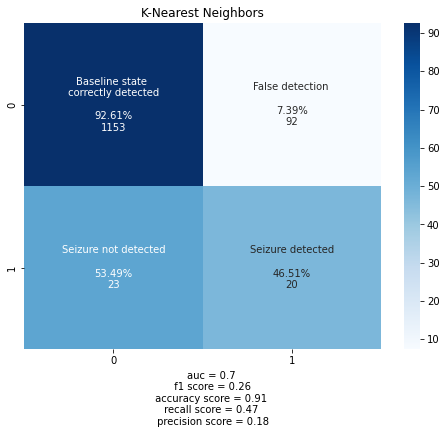

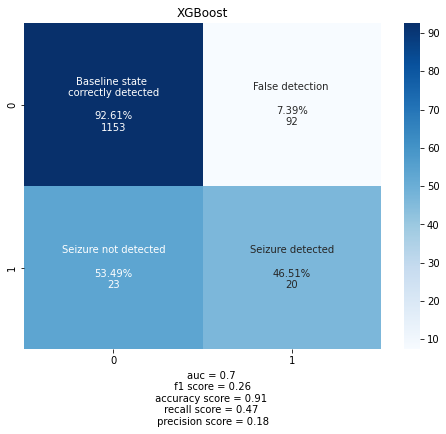

In [69]:
for classifier, name in zip(classifiers, classifier_names):  
    y_pred = classifier.predict(X_test)
    plot_conf_mat(y_test, y_pred, title=name)

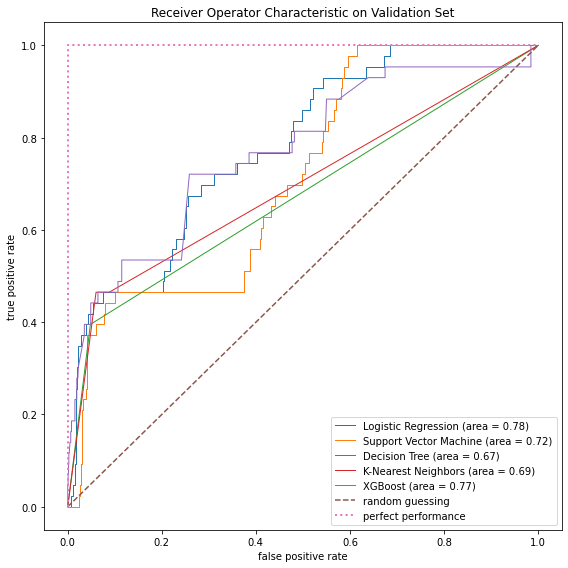

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import re

def ROC(classifiers, classifier_names, X_train, 
        X_val, y_train, y_val):
    fig, ax = plt.subplots(figsize=(8, 8))
    for i, classifer in enumerate(classifiers):
        probas = classifer.fit(X_train,
                                    y_train).predict_proba(X_val)
        fpr, tpr, thresholds = roc_curve(y_val, 
                                         probas[:, 1], 
                                         pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, 
                 tpr, 
                 lw=1, 
                 label=f'{classifier_names[i]} (area = {round(roc_auc,2)})')

    plt.plot([0, 1], 
           [0, 1], 
           linestyle='--', 
           label='random guessing')
    
    plt.plot([0, 0, 1], 
           [0, 1, 1], 
           lw=2, 
           linestyle=':', 
           label='perfect performance')
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('Receiver Operator Characteristic on Validation Set')
    plt.legend(loc="lower right", fontsize ='medium')

    plt.tight_layout()
    plt.show()    


ROC(classifiers, classifier_names, X_train, X_test, y_train, y_test)

### Selected classifier : Xgboost

#### For xgboost we are going to run a cross validation

y train ratio = 4.816656308266003%
y test ratio = 9.412861136999068%
AUC score = 0.876


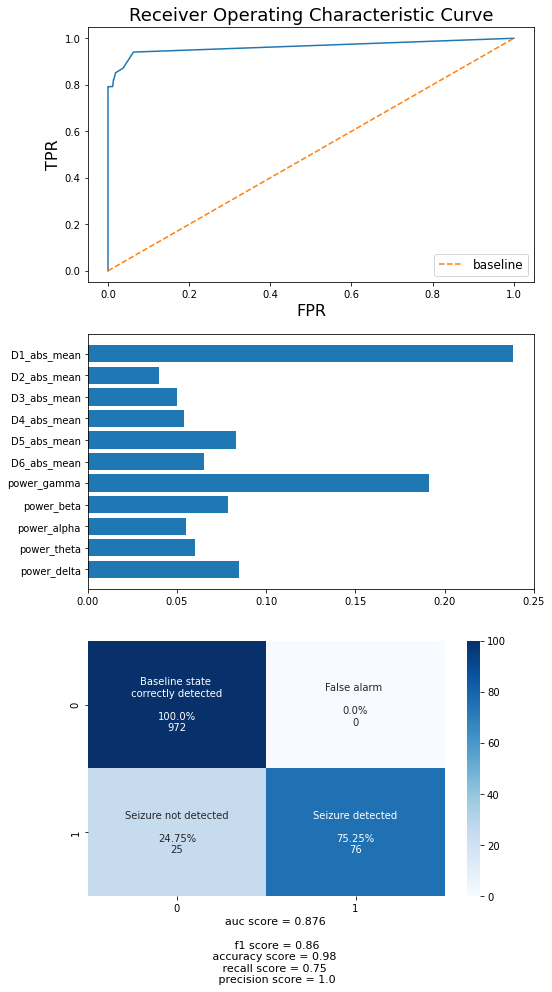

y train ratio = 5.997513983840895%
y test ratio = 5.871388630009319%
AUC score = 0.588


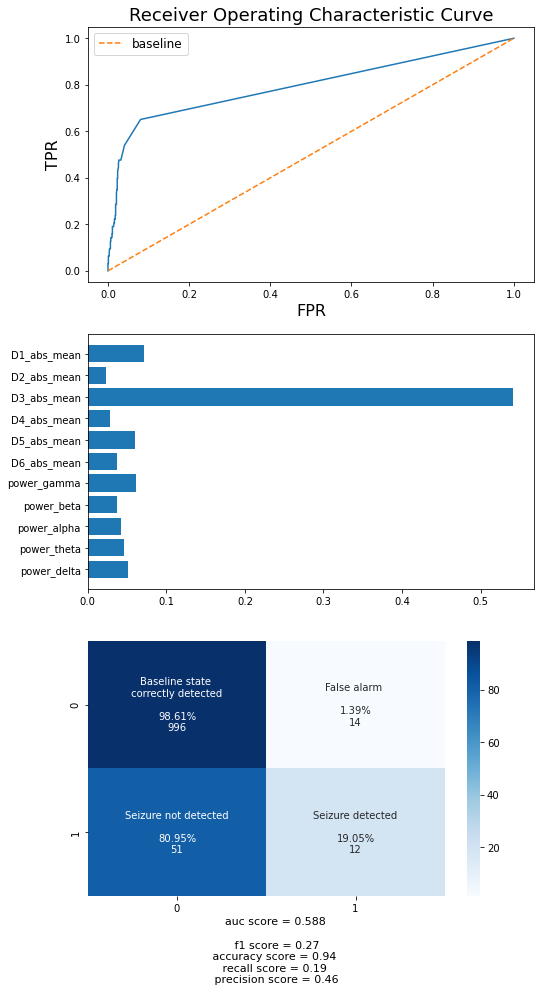

y train ratio = 6.432566811684276%
y test ratio = 4.566635601118359%
AUC score = 0.888


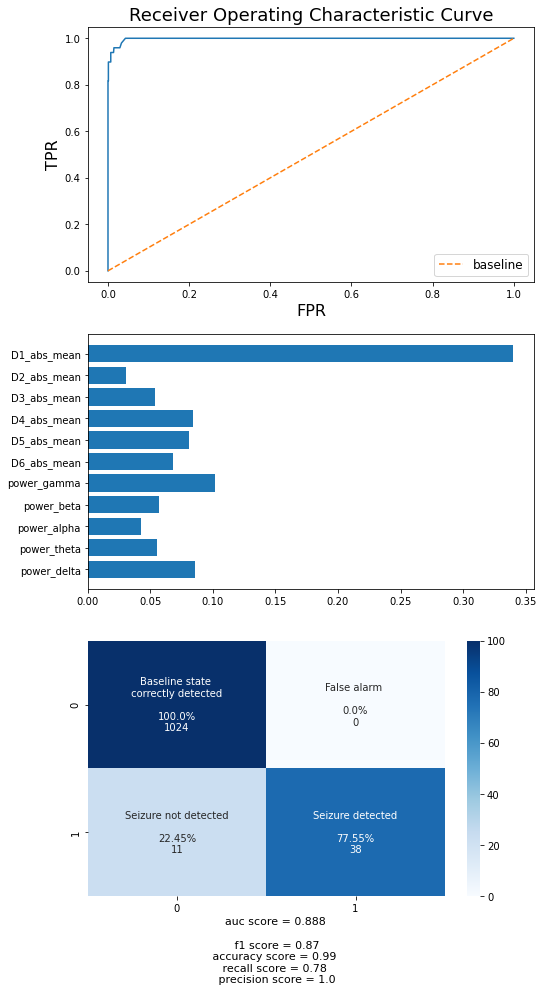

y train ratio = 6.616961789375582%
y test ratio = 4.0111940298507465%
AUC score = 0.692


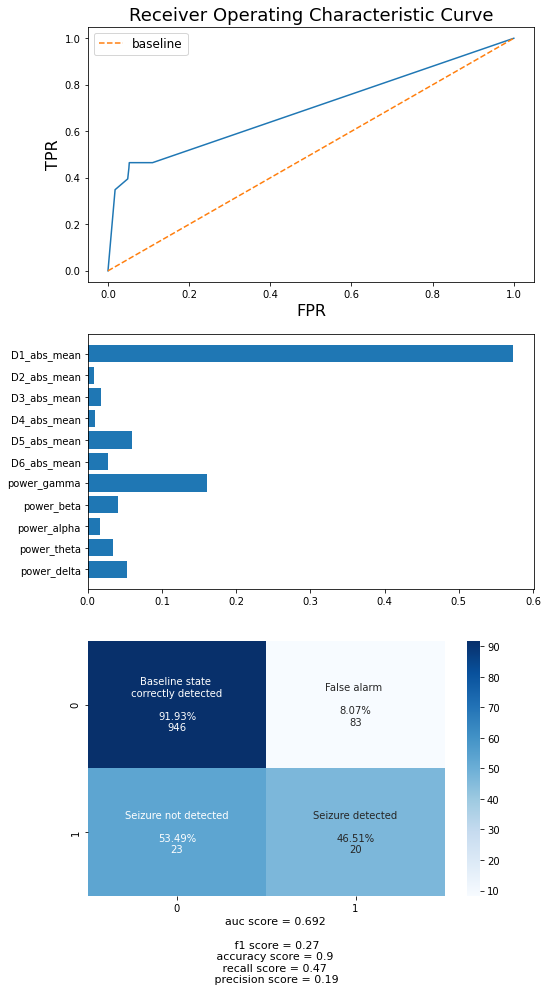

In [47]:
from sklearn.model_selection import KFold, StratifiedKFold
from xgboost import plot_importance

kf = KFold(n_splits=4)
scores = []
kf.get_n_splits(X, y)

for train_index, test_index in kf.split(X):
    
    X_train_chunk, X_test_chunk = X[train_index], X[test_index]
    
    y_train_chunk, y_test_chunk = y[train_index], y[test_index]
    
    print(f'y train ratio = {np.sum(y_train_chunk)/len(y_train_chunk)*100}%')
    print(f'y test ratio = {np.sum(y_test_chunk)/len(y_test_chunk)*100}%')
    model = xgb.XGBClassifier(n_estimators=100,
                              min_child_weight = 1,
                              max_depth = 3,
                              learning_rate= 0.2)
    
    model.fit(X_train_chunk, y_train_chunk)
    y_pred=model.predict(X_test_chunk)
    
    auc = round(roc_auc_score(y_test_chunk,y_pred),3)
    
    scores.append(auc)
    
    print(f'AUC score = {auc}')
    
    
    plt.figure(figsize=(8, 16))
    
    plt.subplot(3,1,1)
    plot_roc_auc(model, X_test_chunk, y_test_chunk)

    plt.subplot(3,1,2)
    plt.barh(final_df.columns, model.feature_importances_)

    plt.subplot(3,1,3)
    cf_matrix = confusion_matrix(y_test_chunk, y_pred)
    cf_matrix_pct = (cf_matrix / cf_matrix.sum(axis=1)[:, np.newaxis])*100
    
    f1 = round(f1_score(y_test_chunk, y_pred), 2)
    acc = round(accuracy_score(y_test_chunk, y_pred), 2)
    recall = round(recall_score(y_test_chunk, y_pred), 2)
    precision = round(precision_score(y_test_chunk, y_pred), 2)
    

    group_names = ["Baseline state \n correctly detected \n","False alarm \n","Seizure not detected\n","Seizure detected\n"]
    group_counts = [f"{round(pct,2)}%\n{round(value,2)}" for value,pct in
                    zip(cf_matrix.flatten(), cf_matrix_pct.flatten())]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_names,group_counts)]

    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix_pct, annot=labels, fmt="", cmap="Blues")
    plt.figtext(0.45, 0.05, f"auc score = {auc}\n\n f1 score = {f1}\n accuracy score = {acc} \n recall score = {recall} \n precision score = {precision}", ha="center", fontsize=11)
    plt.show()

In [35]:
print('AUC scores : ', scores)
print('The mean AUC score accross the 5 fold validation is', round(np.mean(scores), 3))

AUC scores :  [0.876, 0.588, 0.888, 0.692]
The mean AUC score accross the 5 fold validation is 0.761


In [54]:
model_final = xgb.XGBClassifier(n_estimators=100,
                              min_child_weight = 1,
                              max_depth = 3,
                              learning_rate= 0.2)
model_final.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

(291, 11)

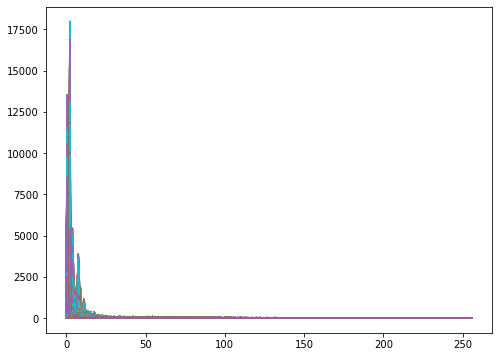

In [61]:
### Final pipeline
## input : 10 min EEG data

def create_window_pipeline(X_val):
    fs=512
    window_size = 18*fs # todo : run optimization on the window selected.
    shift = int(window_size/9)
    data_X = []
    X=X_val
    for i in range(0, int(len(X)-window_size-1), shift):
            data_X.append(X[i:i+window_size])
    return np.array(data_X)
        
def create_df(data):
    tot=pd.DataFrame()
    for d in data:
        df_power = create_power_features(d)
        wavelets_df, _ = create_wavelets(d)
        df_wave_abs = create_abs_mean_from_wavelets_df(wavelets_df)
        df = df_power.join(df_wave_abs)
        if tot.empty:
            tot = df
        else:
            tot = pd.concat([tot, df])
    return tot

X_val = df_train['train_14']

# def predict_pipeline(X_val):
X_wind = create_window_pipeline(X_val)
df_val=create_df(X_wind)
df_val.shape

In [66]:
y_pred_final = model.predict_proba(df_val)[:,1]

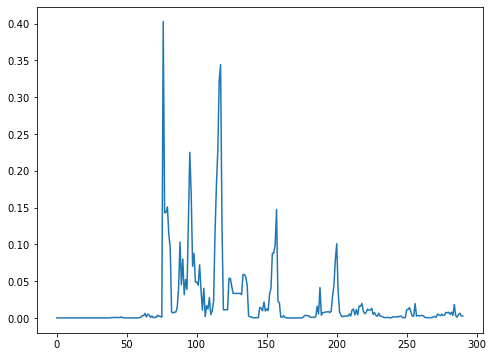

In [67]:
plt.plot(y_pred_final)

## Hyperparameter tuning

The results for the Xgboost classifiers are very promising as we come up with a result of 0.881 AUC.

Let's run a step of hyperparameter tuning and see if we can improve the accuracy of the classifier.

In [36]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

params = {
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
    }

xgbr = xgb.XGBClassifier()

clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='roc_auc',
                         n_iter=30,
                         verbose=5)

clf.fit(X, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END learning_rate=0.1, max_depth=9, min_child_weight=100, n_estimators=400;, score=0.983 total time=   0.4s
[CV 2/5] END learning_rate=0.1, max_depth=9, min_child_weight=100, n_estimators=400;, score=0.983 total time=   0.4s
[CV 3/5] END learning_rate=0.1, max_depth=9, min_child_weight=100, n_estimators=400;, score=0.978 total time=   0.3s
[CV 4/5] END learning_rate=0.1, max_depth=9, min_child_weight=100, n_estimators=400;, score=0.965 total time=   0.3s
[CV 5/5] END learning_rate=0.1, max_depth=9, min_child_weight=100, n_estimators=400;, score=0.714 total time=   0.3s
[CV 1/5] END learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100;, score=0.994 total time=   0.4s
[CV 2/5] END learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100;, score=0.984 total time=   0.4s
[CV 3/5] END learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=100;, score=0.980 total time=   0.4s
[CV 4/5]

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_c...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=30,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [3, 6, 9],
                                        'min_child_weight': [1, 10, 100],
                                        'n_estimators': [100, 400, 800]},
                   scoring='roc_auc', verbose=5)

In [40]:
print("Best parameters:", clf.best_params_)
print(clf.best_score_)

Best parameters: {'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.2}
0.9456556600335301


## MLP

3432 859
AUC score = 0.828


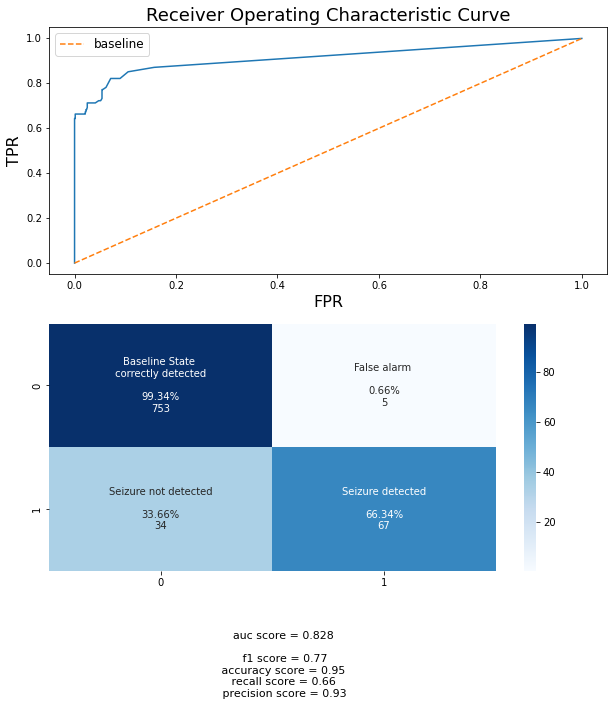

3433 858
AUC score = 0.531


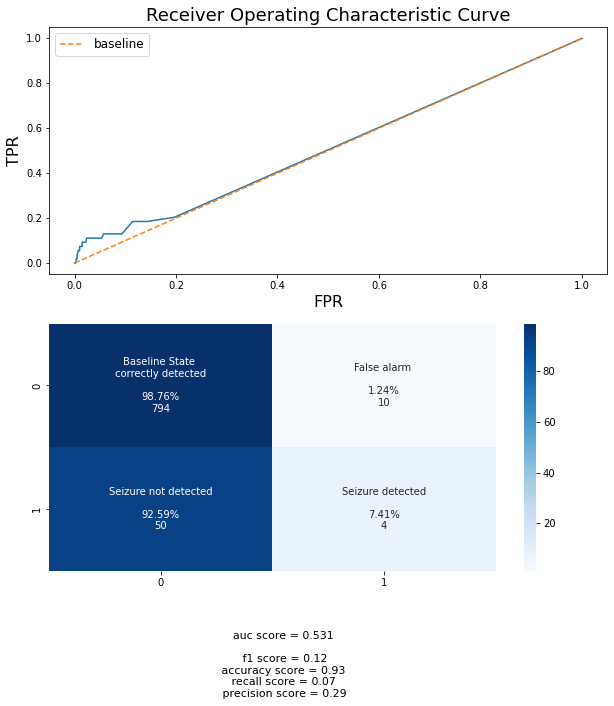

3433 858
AUC score = 0.995


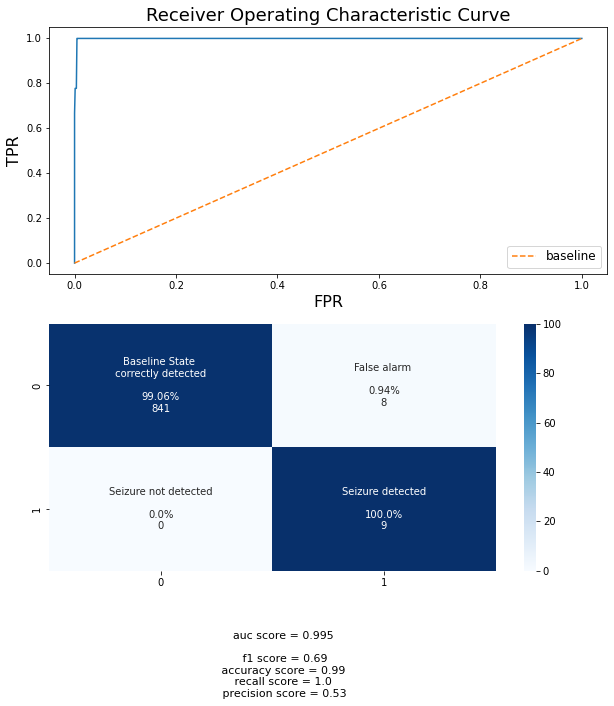

3433 858
AUC score = 0.739


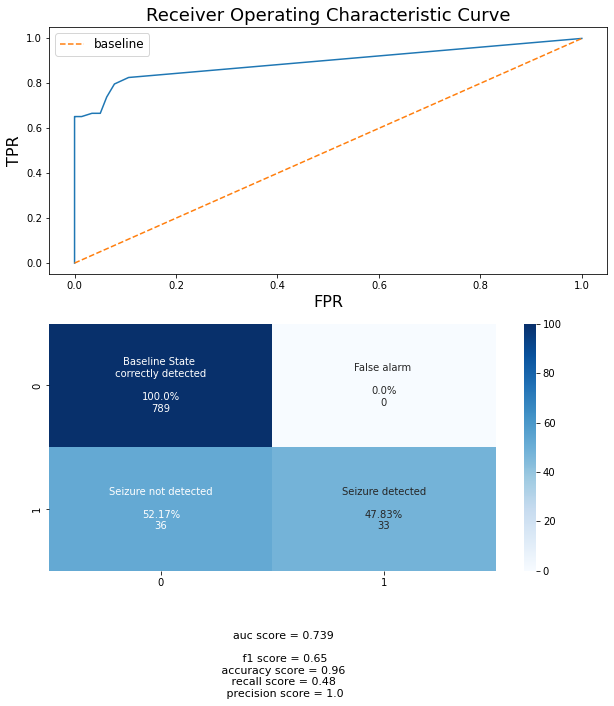

3433 858
AUC score = 0.456


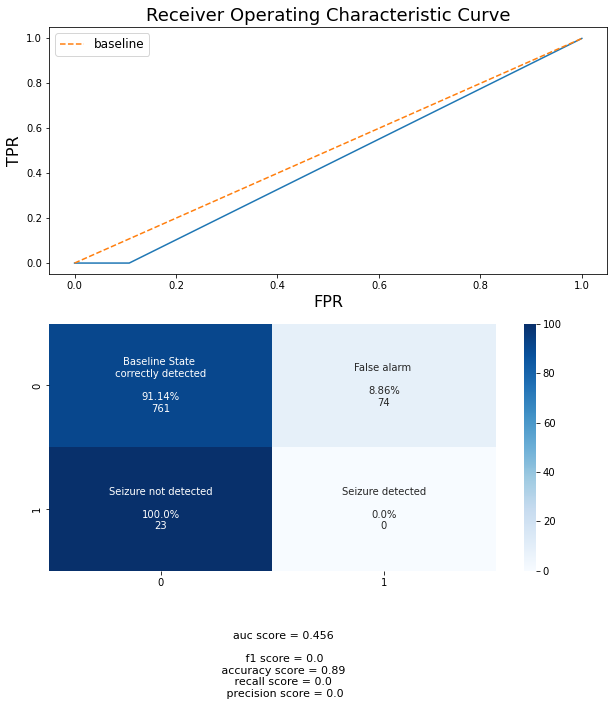

In [38]:
from sklearn.neural_network import MLPClassifier

kf = KFold(n_splits=5)
kf.get_n_splits(X)
scores = []

for train_index, test_index in kf.split(X):
    
    print(len(train_index), len(test_index))
    
    X_train_chunk, X_test_chunk = X[train_index], X[test_index]
    
    y_train_chunk, y_test_chunk = y[train_index], y[test_index]
    
    model = MLPClassifier(hidden_layer_sizes=(100,100), activation='relu',
                          solver='adam', alpha=0.001, batch_size='auto', learning_rate='adaptive')
    
    model.fit(X_train_chunk, y_train_chunk)
    y_pred=model.predict(X_test_chunk)
    
    auc = round(roc_auc_score(y_test_chunk,y_pred),3)
    
    scores.append(auc)
    
    print(f'AUC score = {auc}')
    
    
    plt.figure(figsize=(10, 10))
    
    plt.subplot(2,1,1)
    plot_roc_auc(model, X_test_chunk, y_test_chunk)
    
    plt.subplot(2,1,2)
    cf_matrix = confusion_matrix(y_test_chunk, y_pred)
    cf_matrix_pct = (cf_matrix / cf_matrix.sum(axis=1)[:, np.newaxis])*100

    
    f1 = round(f1_score(y_test_chunk, y_pred), 2)
    acc = round(accuracy_score(y_test_chunk, y_pred), 2)
    recall = round(recall_score(y_test_chunk, y_pred), 2)
    precision = round(precision_score(y_test_chunk, y_pred), 2)
    

    group_names = ["Baseline State \n correctly detected \n","False alarm \n","Seizure not detected\n","Seizure detected\n"]
    group_counts = [f"{round(pct,2)}%\n{round(value,2)}" for value,pct in
                    zip(cf_matrix.flatten(), cf_matrix_pct.flatten())]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_names,group_counts)]

    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix_pct, annot=labels, fmt="", cmap="Blues")
    plt.figtext(0.45, -0.05, f"auc score = {auc}\n\n f1 score = {f1}\n accuracy score = {acc} \n recall score = {recall} \n precision score = {precision}", ha="center", fontsize=11)
    plt.show()

In [39]:
print('AUC scores : ', scores)
print('The mean AUC score accross the 5 fold validation is', round(np.mean(scores), 3))

AUC scores :  [0.828, 0.531, 0.995, 0.739, 0.456]
The mean AUC score accross the 5 fold validation is 0.71


#### CONCLUSION: We obtain an AUC of 0.76 for the XGboost classifier and 0.74 the multi layer perceptron classifier, our 2 best classifiers so far.